# Init Bionic VTOL

In [2]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using TensorBoardLogger
using Logging


using JLD;
using BSON: @save, @load # save mode

In [4]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


In [5]:
# TODO: set as desired
R_TOL = 0.5;
N_WAYPOINTS = 4; # including startpoint, >= 2


SLOW_MODE = false;
TRAINING = false;
EVALUATION = true;
VIDEO = true;

In [6]:
N_WAYPOINTS_office = 9;
WAYPOINTS_office =    
                [[11.0, 3.0, 0.4],
                [7.0, 1.5, 0.4],
                [5.0, 3.0, 0.4],
                [-3.0, 2.5, 0.4], 
                [-6.0, 1.5, 0.4],
                [-8.0, 3.5, 0.4],
                [-9.0, 4.0, 0.4],
                [-9.5, 3.0, 0.4], 
                [-8.5, 1.0, 0.4], 
                [-8.0, 0.5, 0.4]]; 

In [7]:
# TensorBoard
if TRAINING
    logger = TBLogger("tensorboard_PPO", tb_increment)
end

In [8]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

In [9]:
Δt = 0.025;

# Create Reinforcement Learning Environment

In [10]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # All possible actions the agent can take
    observation_space::Space{Vector{ClosedInterval{T}}} # All possible states that the agent can observe.
    state::Vector{T} # Current state
    action::ACT # next action the agent wants to apply in the environment.
    done::Bool # shows whether a terminal condition has been reached.
    t::T # time
    rng::R # random number generator

    name::String # for different naming of multible environoments
    visualization::Bool # activate visualisation (Faster computation without visualisation)
    realtime::Bool # visualization in "real-world" time (only for watching or filming).
    
    # Overall state of the environment. This does not correspond to the observation space of the agent but contains all states that describe the environment.
    x_W::Vector{T} # Position in World frame
    v_B::Vector{T} # Velocity in Body frame
    R_W::Matrix{T} # Rotation (matrix) in World frame
    ω_B::Vector{T} # Rotation velocity in Body frame
    wind_W::Vector{T} # Externel linear velocity acting on the drone
    Δt::T # Time step for physics simulation in seconds

    ###NEW###
    # Current Bonus / Target
    num_waypoints::Int # includig start point
    waypoints::Vector{Vector{T}}
    reached_goal::BitVector
    
    norm_way::T
    progress::T
    progress_prev::T
    current_point::Int
    reached_goal_in_step::Bool
    
    r_tol::T
    projected_position::Vector{T}

    slow_mode::Bool
    ######
end

In [11]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "Crazyflie",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.
    
    # final PWM Values for Crazyflie. The interval definition has no effect in the current implementation.
    action_space = Space(
        ClosedInterval{T}[
            0..1#0..65535, # motor 1
            0..1#0..65535, # motor 2
            0..1#0..65535, # motor 3
            0..1#0..65535, # motor 4
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            typemin(T)..typemax(T), # 1 x
            typemin(T)..typemax(T), # 2 y
            typemin(T)..typemax(T), # 3 z

            typemin(T)..typemax(T), # 4  World Vector UP x
            typemin(T)..typemax(T), # 5  World Vector UP y
            typemin(T)..typemax(T), # 6  World Vector UP z

            typemin(T)..typemax(T), # 7  World Vector FRONT x
            typemin(T)..typemax(T), # 8  World Vector FRONT y
            typemin(T)..typemax(T), # 9  World Vector FRONT z
            
            typemin(T)..typemax(T), # 10 Body velocity along x
            typemin(T)..typemax(T), # 11 Body velocity along y
            typemin(T)..typemax(T), # 12 Body velocity along z
            
            typemin(T)..typemax(T), # 13 Body rotational velocity around x
            typemin(T)..typemax(T), # 14 Body rotational velocity around y
            typemin(T)..typemax(T), # 15 Body rotational velocity around z
            
            ###NEW###
            typemin(T)..typemax(T), # 16 position error along x (next gate - current position)
            typemin(T)..typemax(T), # 17 position error along y (next gate - current position)
            typemin(T)..typemax(T), # 18 position error along z (next gate - current position)
            
            typemin(T)..typemax(T), # 19 way to next next gate x (next next gate - next gate)
            typemin(T)..typemax(T), # 20 way to next next gate y (next next gate - next gate)
            typemin(T)..typemax(T), # 21 way to next next gate z (next next gate - next gate)
            ######
            ], 
    )

    ###NEW###
#     num_waypoints = N_WAYPOINTS
    num_waypoints = N_WAYPOINTS_office # number of waypoints, includig start point #todo
    
#     waypoints = generate_straight_trajectory(num_waypoints + 1) # trajectory with num_waypoints waypoints (+ start point), (with dummy points) 
    waypoints = WAYPOINTS_office
    
    reached_goal = falses(num_waypoints)
    
    norm_way = 0.0 
    for i in 1:(num_waypoints - 1)
        norm_way += norm(waypoints[i] - waypoints[i + 1])
    end
    ######
    
    if visualization
        create_Crazyflie(name, actuators = true);
        visualize_waypoints(waypoints[1:num_waypoints], 0.05)

        set_Crazyflie_actuators(name, [0.0; 0.0; 0.0; 0.0]);
        set_transform(name, [0.0; 0.0; 0.0] ,one(QuatRotation));
        set_arrow(string(name, "vel"), color_vec=[0.0; 1.0; 0.0; 1.0]);
        transform_arrow(string(name, "vel"), [0.0; 0.0; 0.0], [0.0; 0.0; 1.0], max_head_radius=0.05)
#         set_arrow(string(name, "_vel_current"), color_vec=[1.0; 0.0; 0.0; 1.0]);
#         transform_arrow(string(name, "_vel_current"), [0.0; 0.0; 0.0], [0.0; 0.0; 1.0], max_head_radius=0.02)                  
    end
    


    environment = VtolEnv(
        action_space,
        state_space,
        zeros(T, length(state_space)), # current state, needs to be extended.
        [0.25; 0.25; 0.25; 0.25],#rand(action_space), 
        false, # episode done ?
        0.0, # time
        rng, # random number generator  

        name,
        visualization,
        realtime,

        zeros(T, 3), # x_W
        zeros(T, 3), # v_B
        Matrix(one(QuatRotation)), # Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        Δt, # Δt

        num_waypoints, # includig start point
        waypoints, 
        reached_goal,

        norm_way, # norm_way
        0.0, # progress
        0.0, # progress_prev
        2, # current point
        false, # reached_goal_in_step
        
        R_TOL, # r_tol
        zeros(T, 3), # projected_position

        SLOW_MODE # slow_mode

        )
    
    
    RLBase.reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

In [12]:
methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at In[11]:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, num_waypoints::Int64, waypoints::Array{Vector{T}, 1}, reached_goal::BitVector, norm_way::T, progress::T, progress_prev::T, current_point::Int64, reached_goal_in_step::Bool, r_tol::T, projected_position::Vector{T}, slow_mode::Bool) where {A, T, ACT, R<:AbstractRNG} in Main at In[10]:2

# Define the RL interface

In [13]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [14]:
function scale_for_slowmode(slow_mode::Bool, v_min::T, v_max::T, d_max::T, x_W::Vector{T}, projected_position::Vector{T}, v_B::Vector{T}) where T
    
    if slow_mode == false
        return 1
    else
        if norm(v_B) > v_max
            s_vmax = 10^(v_max - norm(v_B))
        else
            s_vmax = 1
        end

        if norm(v_B) < v_min
            s_vmin = 10^(norm(v_B) - v_min)
        else
            s_vmin = 1
        end

        if norm(x_W - projected_position) > d_max
            s_gd = exp(-norm(x_W - projected_position) + d_max)
        else
            s_gd = 1
        end
        s = s_vmax * s_vmin * s_gd
    end
    return s
end;

In [15]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    
    if env.slow_mode
        v_min = 1.0 # min velocity
        v_max = 3.0 # max velocity
        d_max = 0.5 
    else
        v_min = 4.0 # min velocity
        v_max = 50.0 # max velocity
        d_max = 1.0 
    end


    s = scale_for_slowmode(true, v_min, v_max, d_max, env.x_W, env.projected_position, env.v_B)
    
    k_p = 5.0 * s #/ env.norm_way # factor for progress (between current position and last position) reward 
    r_p = (env.progress - env.progress_prev); # reward for progress (between current position and last position)

    k_s = s * (2 * v_max * env.Δt) / env.norm_way # factor for reached distance (overall) reward
    r_s = env.progress # reward for reached distance (overall)
    
    k_wp = 50.0 # factor for reached gate reward
    r_wp = 0.0 # reward for reached gate
    if env.reached_goal_in_step
        r_wp = exp(-norm(env.x_W - env.waypoints[env.current_point - 1])/env.r_tol)
    end 

    # factor for too high body rate penalty
    if env.slow_mode
        k_ω = 0.01
    else
        k_ω = 0.001
    end
    #norm_ω = norm(env.ω_B[3]) # penalty for body rate
    norm_ω = norm(env.ω_B) # penalty for body rate

    if env.x_W[3] < 0
        fall = 1
    else
        fall = 0
    end
    
    if !env.slow_mode
        k_s /= env.norm_way
        k_p /= env.norm_way
    end
    
    return k_p * r_p + k_s * r_s + k_wp * r_wp - k_ω * norm_ω - fall
    
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [16]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    
#     env.waypoints = generate_straight_trajectory(env.num_waypoints + 1); # Dummy points
    env.num_waypoints = N_WAYPOINTS_office
    env.waypoints = WAYPOINTS_office
    
    env.x_W = env.waypoints[1];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(one(QuatRotation)); # Identity matrix (no rotation)
    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];

    env.reached_goal = falses(env.num_waypoints);
    env.reached_goal[1] = true; # set first point to reached (start point)
    
    env.current_point = 2;
    env.reached_goal_in_step = false;
    #env.r_tol = 0.3;
    
    if env.visualization
        visualize_waypoints(env.waypoints[1:env.num_waypoints], 0.05); 
    end
    
    norm_way = 0.0 
    for i in 1:(env.num_waypoints - 1)
        norm_way += norm(env.waypoints[i] - env.waypoints[i + 1])
    end
    
    env.norm_way = norm_way
    env.progress = 0.0;
    env.progress_prev = 0.0;
        

    env.state = [env.x_W[1]; # 1 position along x
                 env.x_W[2]; # 2 position along y
                 env.x_W[3]; # 3 position along z

                 env.R_W[1,1];
                 env.R_W[2,1];
                 env.R_W[3,1];
        
                 env.R_W[1,3]; # 4  World Vector UP x
                 env.R_W[2,3]; # 5  World Vector UP y
                 env.R_W[3,3]; # 6  World Vector UP z

#                  env.R_W[1,1]; # 7  World Vector FRONT x
#                  env.R_W[2,1]; # 8  World Vector FRONT y
#                  env.R_W[3,1]; # 9  World Vector FRONT z

                 env.v_B[1]; #  10 Body velocity along x
                 env.v_B[2]; #  11 Body velocity along y
                 env.v_B[3]; #  12 Body velocity along z

                 env.ω_B[1]; #  13  Body rotational velocity around x
                 env.ω_B[2]; #  14  Body rotational velocity around y
                 env.ω_B[3]; #  15  Body rotational velocity around z

                 env.waypoints[2][1] - env.x_W[1]; # 16 position error to next gate along x
                 env.waypoints[2][2] - env.x_W[2]; # 17 position error to next gate along z
                 env.waypoints[2][3] - env.x_W[3]; # 18 position error to next gate along z
                 
                 env.waypoints[3][1] - env.waypoints[2][1]; # 19 way to next next gate x 
                 env.waypoints[3][2] - env.waypoints[2][2]; # 20 way to next next gate y
                 env.waypoints[3][3] - env.waypoints[2][3]]  # 21 way to next next gate z 
    

    env.t = 0.0; # time 0s
    env.action = [0.25; 0.25; 0.25; 0.25] # normalized 
    #env.last_action = [0.255; 0.255; 0.255; 0.255] # normalized
    #env.current_action = [0.255; 0.255; 0.255; 0.255] # normalized

    env.done = false # reset termination

    env.projected_position = [0; 0; 0]
    
    if env.visualization
        # Visualize initial state
        set_transform(env.name, env.x_W,QuatRotation(env.R_W));
        set_Crazyflie_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
        #transform_arrow(string(env.name, "_vel"), env.x_W, env.v_W_target, max_head_radius=0.05) 
        transform_arrow(string(env.name, "vel"), env.x_W, [0.0; 0.0; 0.0], max_head_radius=0.05) 
    end
    
    nothing # return nothing
end;

In [17]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)


    # call the step on the environoment with the next action 
    _step!(env, a)
        
end

In [18]:
env = VtolEnv();

In [19]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at In[17]:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [20]:
function scale_actions(next_action)
    return next_action*22000.0
end

scale_actions (generic function with 1 method)

In [21]:
function _step!(env::VtolEnv, next_action)
    

    #env.last_action = copy(env.current_action)
    #env.current_action[1] = next_action[1]
    #env.current_action[2] = next_action[2]
    #env.current_action[3] = next_action[3]
    #env.current_action[4] = next_action[4]
    
    
    
    scaled_actions = scale_actions.(next_action) # between 0 and 1 for neual network
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = crazyflie_model(scaled_actions);
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, env.t = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, crazyflie_param)

    
    env.reached_goal_in_step = false;
    if norm(env.x_W - env.waypoints[env.current_point]) < env.r_tol
        env.reached_goal_in_step = true;
        env.reached_goal[env.current_point] = true;
        env.current_point += 1;
    end
        
            
    # calculate progress on trajectory
    env.progress_prev = env.progress
    
    current_progress = 0.0
    line_segment, env.projected_position = calculate_progress(env.waypoints, env.x_W)
    
    #env.current_point = line_segment + 1

    for i in 2:(line_segment)
       current_progress +=  norm(env.waypoints[i] - env.waypoints[i - 1])  
    end
    current_progress += norm(env.waypoints[line_segment] - env.projected_position)
    
    env.progress = current_progress
    

    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end



    if env.visualization
        set_transform(env.name, env.x_W,QuatRotation(env.R_W));
        set_Crazyflie_actuators(env.name, next_action[1:4])
        #transform_arrow(string(env.name, "_vel"), env.x_W, env.v_W_target, max_head_radius=0.05)               
        transform_arrow(string(env.name, "vel"), env.x_W, env.R_W*env.v_B, max_head_radius=0.05) 
    
        for i in eachindex(env.reached_goal)
            if env.reached_goal[i]
                create_sphere("fixgoal_$i", 0.05, color=RGBA{Float32}(1.0, 0.0, 0.0, 1.0));
                set_transform("fixgoal_$i", env.waypoints[i]);
            end
        end

    end
    
    
    #v_B_target = transpose(env.R_W)*env.v_W_target
    
    
    # State space
    env.state[1] = env.x_W[1];
    env.state[2] = env.x_W[2];
    env.state[3] = env.x_W[3];
    
    env.state[4] = env.R_W[1,1] # 1  World Vector UP x
    env.state[5] = env.R_W[2,1] # 2  World Vector UP y
    env.state[6] = env.R_W[3,1] # 3  World Vector UP z

    env.state[7] = env.R_W[1,3] # 4  World Vector FRONT x
    env.state[8] = env.R_W[2,3] # 5  World Vector FRONT y
    env.state[9] = env.R_W[3,3] # 6  World Vector FRONT z
        
    env.state[10] = env.v_B[1] # 7  Body velocity along x
    env.state[11] = env.v_B[2] # 8  Body velocity along y
    env.state[12] = env.v_B[3] # 9  Body velocity along z

    env.state[13] = env.ω_B[1] # 10 Body rotational velocity around x
    env.state[14] = env.ω_B[2] # 11 Body rotational velocity around y
    env.state[15] = env.ω_B[3] # 12 Body rotational velocity around z

    env.state[16] = env.waypoints[env.current_point][1] - env.x_W[1] # 13 position error to next gate along x
    env.state[17] = env.waypoints[env.current_point][2] - env.x_W[2]; # 14 position error to next gate along z
    env.state[18] = env.waypoints[env.current_point][3] - env.x_W[3]; # 15 position error to next gate along z
                 
    if env.current_point <= env.num_waypoints
        env.state[19] = env.waypoints[env.current_point + 1][1] - env.waypoints[env.current_point][1] ; # 16 way to next next gate x (next next gate - next gate), dummy integriert
        env.state[20] = env.waypoints[env.current_point + 1][2] - env.waypoints[env.current_point][2]; # 17 way to next next gate y (next next gate - next gate), dummy integriert
        env.state[21] = env.waypoints[env.current_point + 1][3] - env.waypoints[env.current_point][3]; # 18 way to next next gate z (next next gate - next gate), dummy integriert
    end

    
    
    # Termination criteria
    env.done = #true
        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
         norm(env.ω_B) > 100.0 || 
         norm(env.v_B) > 100.0 || # stop if body is too fast_point 
        env.x_W[3] < -1.0 || # stop if body is below -5m
        env.t > env.num_waypoints * 3.0 ||# stop after 3s per point 
        norm(env.x_W - env.projected_position) > 5.0 || # too far off the path 
        env.reached_goal == trues(env.num_waypoints)

    nothing
end;

In [22]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  2.2s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.677111820851641e9, 1.677111823055725e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [23]:
seed = 123    
rng = StableRNG(seed)
N_ENV = 8
UPDATE_FREQ = 1024
    
    
    # define multiple environments for parallel training
    env = MultiThreadEnv([
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "cf_PPO$i") for i in 1:N_ENV
    ])



MultiThreadEnv(8 x VtolEnv)

In [24]:
# Define the function approximator
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 256, tanh; initW = glorot_uniform(rng)),
                    Dense(256, 256, tanh; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(256, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(256, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 256, tanh; initW = glorot_uniform(rng)),
                    Dense(256, 256, tanh; initW = glorot_uniform(rng)),
                    Dense(256, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-4),
            );

In [25]:
    agent = Agent( # A wrapper of an AbstractPolicy
         

        # AbstractPolicy: the policy to use
        policy = PPOPolicy(;
                    approximator = approximator |> cpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


In [26]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)
    if SLOW_MODE
        f = joinpath("./office_test/RL_models_slow/", "cf_ppo_$(t).bson") #todo
    else
        f = joinpath("./office_test/RL_models_fast/", "cf_ppo_$(t).bson") 
    end
    @save f model
    println("parameters at step $t saved to $f")
end;


In [27]:
function loadModel()
    if SLOW_MODE
        f = joinpath("./RL_models_slow/", "cf_ppo_$(load_from_slow_step).bson")
#         f = joinpath("./office_test/RL_models_slow/", "cf_ppo_1000000.bson") #todo
    else
        f = joinpath("./office_test/RL_models_slow/", "cf_ppo_$(load_from_fast_step).bson") # todo
    end
    @load f model
    return model
end;

In [28]:
function validate_policy(t, agent, env)
    # for validation extract the policy from the agend
    run(agent.policy, test_env, StopAfterEpisode(1), 
        ComposedHook(
        episode_test_step_hook, 
        episode_test_reward_hook
    ),
        )
    # the result of the hook
    reward = round((episode_test_reward_hook.rewards[end]),digits = 3)
    length = episode_test_step_hook.steps[end-1]
    
    println("step: ", t, " reward : ",reward, " length: ", length)

    with_logger(logger) do
        @info "evaluating" avg_length = length  avg_reward = reward  log_step_increment = 0
    end
end;

episode_test_reward_hook = TotalRewardPerEpisode( is_display_on_exit=false)
episode_test_step_hook = StepsPerEpisode()
# create a env only for reward test

test_env = VtolEnv(;name = "test_cf", visualization = true, realtime = true);
#test_env = VtolEnv(;name = "test_cf", visualization = false, realtime = false);

In [29]:
# number of steps
steps_slow = 2_000_000
steps_fast = 4_000_000
load_from_slow_step = 30_000_000 #30_000_000 # TODO: choose slow model
load_from_fast_step = 2_000_000 #30_000_000 # TODO: choose fast model

save_freq = 100_000
validate_freq = 100_000

steps = 0
if SLOW_MODE
    steps = steps_slow
else
    steps = steps_fast
end

4000000

In [30]:
# Define hook which is called during the training
total_batch_reward_per_episode = TotalBatchRewardPerEpisode(N_ENV, is_display_on_exit = false)
hook = ComposedHook(
    total_batch_reward_per_episode,
    DoEveryNStep(saveModel, n=save_freq),
    DoEveryNStep(validate_policy, n=validate_freq),
    #=
    DoEveryNStep() do t, agent, env
        p = agent.policy
        with_logger(logger) do
            @info "training" loss = mean(p.loss)  actor_loss = mean(p.actor_loss)  critic_loss = mean(p.critic_loss)
        end
    end,
    =#
    DoEveryNStep() do t, agent, env
        with_logger(logger) do
            rewards = [
                total_batch_reward_per_episode.rewards[i][end] for i in 1:length(env)  if is_terminated(env[i])
                    ]
            if length(rewards) > 0
                @info "training" reward = mean(rewards)
            end
        end
    end,
    #=
    DoEveryNStep() do t, agent, env
        with_logger(logger) do
            @info "training" action_thrust_1 = env[1].action[1]  action_thrust_2 = env[1].action[2] action_thrust_3 = env[1].action[3] action_thrust_4 = env[1].action[4]
        end
    end,
    =#
);

In [31]:
agent.policy.approximator = loadModel(); 

In [32]:
if TRAINING
    ReinforcementLearning.run(
        agent,
        env,
        StopAfterStep(steps),
        hook
    )
end

In [33]:
if TRAINING
    plot(episode_test_reward_hook.rewards)
end

In [34]:
if TRAINING
    plot(episode_test_step_hook.steps[1:2:end])
end

In [35]:
close_visualization(); # closes the MeshCat visualization

# Evaluation

In [36]:
test_env = VtolEnv(;name = "test_cf");

In [37]:
function loadModel(path, num)
    f = joinpath(path, "cf_ppo_$num.bson") 
    @load f model
    return model
end;

In [38]:
function validate(num_models, num_test)
    episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
    # create a env only for reward test
    for i in 1:num_models
          
        sum_rewards_model = 0;
        sum_successes_model = 0;
        sum_avg_vel_model = 0;
        sum_compl_time = 0;
        n_success = 0;
        
        for exp in 1:num_test
            if SLOW_MODE
                path = "./office_test/RL_models_slow/"
            else
                path = "./office_test/RL_models_fast/"
            end
            agent.policy.approximator = loadModel(path, i * save_freq + 2_000_000); 
            RLBase.reset!(test_env)
            
            run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
            # the result of the hook
            sum_rewards_model += episode_test_reward_hook.rewards[end];
            
            if test_env.reached_goal == trues(test_env.num_waypoints)
                n_success += 1
                sum_avg_vel_model += test_env.norm_way / test_env.t
                sum_compl_time += test_env.t
                if best_compl_time[i] > test_env.t
                    best_compl_time[i] = test_env.t
                end
            end
        end
        
        rewards[i] = sum_rewards_model / num_test;
        success_rate[i] = n_success / num_test;
        if n_success > 0
            avg_velocity[i] = sum_avg_vel_model / n_success;
            avg_compl_time[i] = sum_compl_time / n_success;
        else
            avg_velocity[i] = NaN
            avg_compl_time[i] = NaN
        end
        percent = percent = round(i * 100 / num_models, digits=2)
        print("progress: $(percent)%   \r")
        flush(stdout)
        
    end
    
    
end;

In [39]:
if EVALUATION
    
    NUM_MODELS = Int(steps / save_freq);  
    NUM_TEST = 30; # TODO: change as desired 

    rewards = zeros(NUM_MODELS, 1);
    success_rate = zeros(NUM_MODELS, 1);
    avg_velocity = zeros(NUM_MODELS, 1);
    avg_compl_time = zeros(NUM_MODELS, 1);
    best_compl_time = zeros(NUM_MODELS, 1);
    best_compl_time[1:end] .= 500
    
    validate(NUM_MODELS, NUM_TEST);
    
    for i in 1:NUM_MODELS
        if best_compl_time[i] == 500
            best_compl_time[i] = NaN
        end
    end
end;

In [40]:
if EVALUATION
    results_path = pwd() * "/office_test/plots/";
    if SLOW_MODE
        results_path = results_path * "slow/"
    else
        results_path = results_path * "fast/"
    end
    
    save(results_path * "iterations.jld", "data", [1:NUM_MODELS] * save_freq) 
    
    save(results_path * "avg_comp_time.jld", "data", avg_compl_time)
    
    save(results_path * "avg_velocity.jld", "data", avg_velocity)
    
    save(results_path * "reward.jld", "data", rewards) 
        
    save(results_path * "success_rate.jld", "data", success_rate)
    
    save(results_path * "best_compl_time.jld", "data", best_compl_time)
end;

In [41]:
results_path = pwd() * "/office_test/plots/";
if SLOW_MODE
    results_path = results_path * "slow/"
else
    results_path = results_path * "fast/"
end

iterations = load(results_path * "iterations.jld")["data"];
avg_compl_time = load(results_path * "avg_comp_time.jld")["data"];
avg_velocity = load(results_path * "avg_velocity.jld")["data"];
rewards = load(results_path * "reward.jld")["data"];
success_rate = load(results_path * "success_rate.jld")["data"];
best_compl_time = load(results_path * "best_compl_time.jld")["data"];

In [42]:
fig_path = pwd() * "/office_test/plots/";
if SLOW_MODE
    fig_path = fig_path * "slow/"
else
    fig_path = fig_path * "fast/"
end

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_PPO_quadcopter_3D/office_test/plots/fast/"

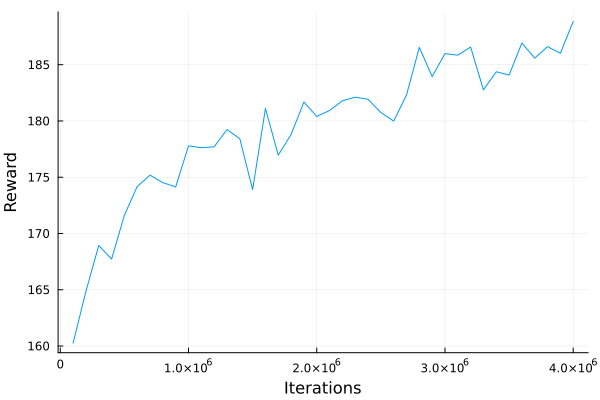

In [43]:
plot(iterations, rewards, xlabel="Iterations", ylabel="Reward", legend = false, xformatter = :scientific)

In [44]:
savefig(fig_path * "reward.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_PPO_quadcopter_3D/office_test/plots/fast/reward.svg"

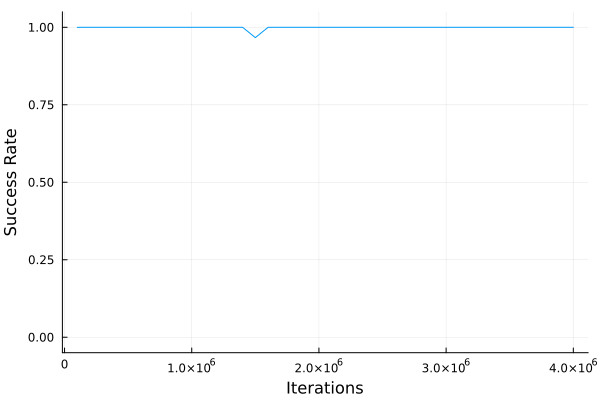

In [45]:
plot(iterations, success_rate, xlabel="Iterations", ylabel="Success Rate", legend = false, xformatter = :scientific, ylims=(-0.05,1.05))

In [46]:
savefig(fig_path * "success_rate.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_PPO_quadcopter_3D/office_test/plots/fast/success_rate.svg"

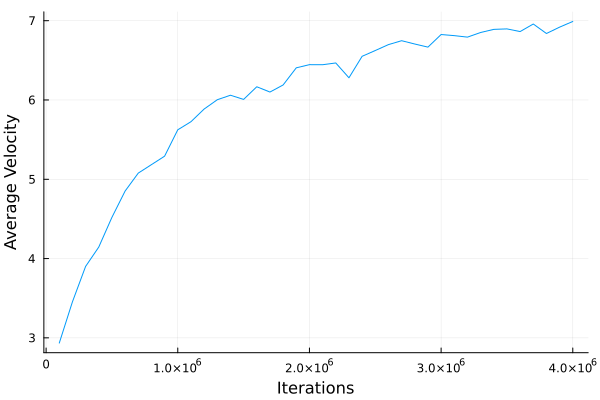

In [47]:
plot(iterations, avg_velocity, xlabel="Iterations", ylabel="Average Velocity", legend = false, xformatter = :scientific)

In [48]:
savefig(fig_path * "avg_velocity.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_PPO_quadcopter_3D/office_test/plots/fast/avg_velocity.svg"

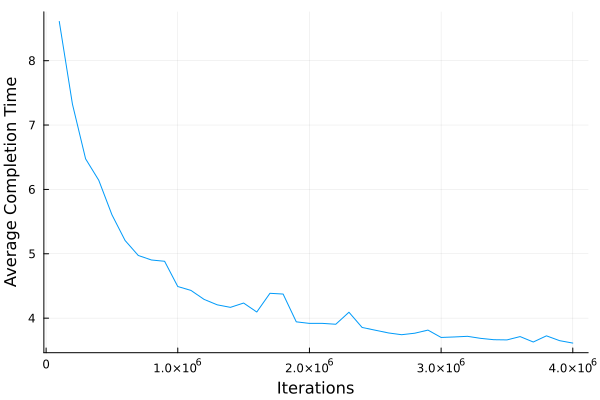

In [49]:
plot(iterations, avg_compl_time, xlabel="Iterations", ylabel="Average Completion Time", legend = false, xformatter = :scientific)

In [50]:
savefig(fig_path * "best_comp_time.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_PPO_quadcopter_3D/office_test/plots/fast/best_comp_time.svg"

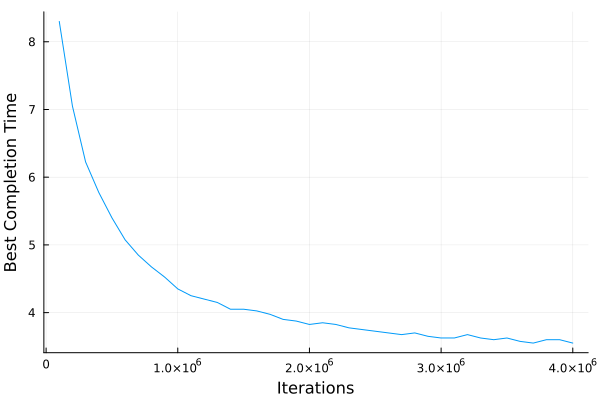

In [51]:
plot(iterations, best_compl_time, xlabel="Iterations", ylabel="Best Completion Time", legend = false, xformatter = :scientific)

In [52]:
savefig(fig_path * "best_comp_time.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_PPO_quadcopter_3D/office_test/plots/fast/best_comp_time.svg"

In [53]:
best_compl_time

40×1 Matrix{Float64}:
 8.30000000000005
 7.050000000000033
 6.225000000000021
 5.775000000000015
 5.400000000000009
 5.075000000000005
 4.850000000000001
 4.674999999999999
 4.524999999999997
 4.349999999999994
 4.249999999999993
 4.199999999999992
 4.1499999999999915
 ⋮
 3.649999999999991
 3.624999999999991
 3.624999999999991
 3.674999999999991
 3.624999999999991
 3.599999999999991
 3.624999999999991
 3.5749999999999913
 3.5499999999999914
 3.599999999999991
 3.599999999999991
 3.5499999999999914

In [ ]:
avg_compl_time

# Create Videos

In [54]:
create_visualization();
create_Office("office");

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


In [55]:
if VIDEO  
  # TODO: load_model as desired
    vid_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);
    
    if SLOW_MODE
        path = "./office_test/RL_models_slow/"
        load_model = 2_000_000
        println("slow mode")
    else
        path = "./office_test/RL_models_fast/"
        load_model = 6_000_000
        println("fast mode")
    end
    agent.policy.approximator = loadModel(path,load_model);
    for i in 1:30
        sleep(5)
        RLBase.reset!(vid_env)
        run(agent.policy, vid_env, StopAfterEpisode(1))
    end
end;

fast mode


In [56]:
close_visualization();

done